# Warm up session
1. Load the time series 'MBA_ECG14046_data_22.out' in the ECG dataset
2. Plot the time series
3. Highlight the anomalies in red
4. Calculate and display the average number of anomalies.

In [185]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

## Load the time series

In [186]:
# Paths & Directories
dataset_path = os.path.join('..', 'data', 'TSB-UAD-Public', 'ECG')
file_name = 'MBA_ECG803_data.out'
file_path = os.path.join(dataset_path, file_name)

In [187]:
# Load the timeseries
df = pd.read_csv(file_path, header=None)
data = df[0].to_numpy()
label = df[1].to_numpy()

## Plot the time series and its anomalies

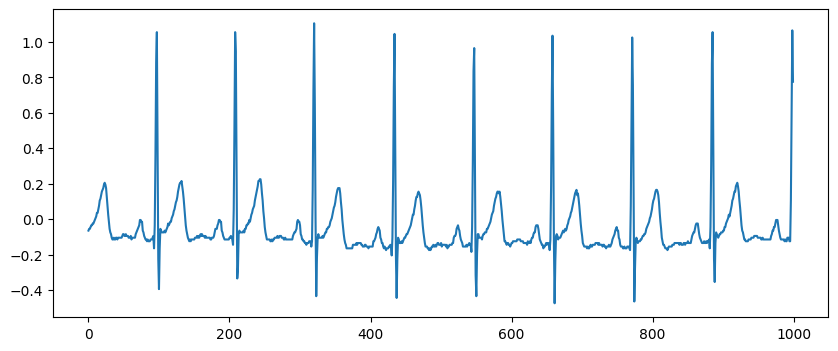

In [188]:
plt.figure(figsize=(10, 4))
plt.plot(data[:1000])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


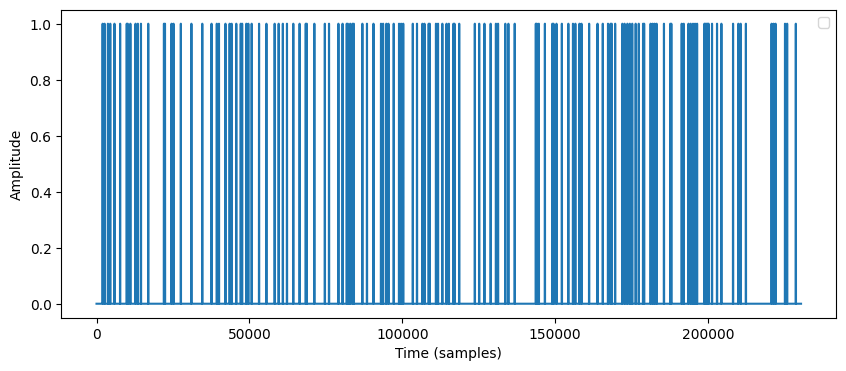

In [189]:
plt.figure(figsize=(10, 4))
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.plot(label)
plt.show()

## Highlight the anomalies in red

**Question 1:** Write a function that, given a time series and its label, generates a plot of the time series with its anomalies displayed on top of it in red.

**Hint:** Use matplotlib :D

In [190]:
# TODO: Implement the following function
def plot_signal_with_anomalies(x, y, title=None):
    # Plot the ECG signal
    plt.plot(x, label="ECG Signal", color='blue')

    # Identify the anomalies (assuming label '1' indicates anomalies)
    anomalies = np.where(y == 1)[0]
    
    # Plot the anomalies in red
    plt.scatter(anomalies, x[anomalies], color='red', label="Anomalies", zorder=5)

    # Add labels and legend
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

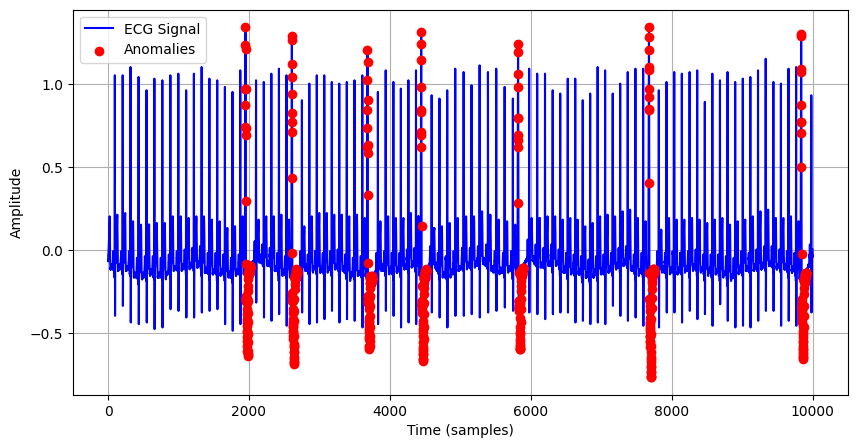

In [191]:
# Test your function here
x = data[:10000]
y = label[:10000]

plt.figure(figsize=(10, 5))
plot_signal_with_anomalies(x, y, title=file_path)
plt.show()

## Find the average number of anomalies for the whole dataset

**Question 2:** Write a function that, given the label of a time series, returns the number of anomalies found in the label.

**Example:** label = 100011111100001110001, expected output = 3 

In [192]:
# TODO: Implement the following function
def compute_number_of_anomalies(y):
    # Count the number of anomalies 
    count = 0
    if y[0] == 1:
        count += 1
    for i in range(1, len(y)):
        if y[i] == 1 and y[i - 1] == 0:
            count += 1
    return count
    
    
compute_number_of_anomalies(label)

147

### Load the whole ECG dataset

In [193]:
# List all files in the dataset directory with '.out' extension
files = [f for f in os.listdir(dataset_path) if f.endswith('.out')]
files_list = []

# Load them
for file_name in files:
    file_path = os.path.join(dataset_path, file_name)
    df = pd.read_csv(file_path, header=None)
    files_list.append({
        "dataset": "ECG",
        "file_name": file_name,
        "data": df[0].to_numpy(),
        "label": df[1].to_numpy(),
    })

### Calculate the average number of anomalies in the ECG dataset

**Question 3:** Calculate the average number of anomalies in the ECG dataset and print the result.

In [194]:
# TODO: Compute the average number of anomalies in all files
avg_n_anomalies = 0

start = time.time()
total_anomalies = 0
num_files = len(files_list)

for file in files_list:
     # Compute the number of anomalies for the current file
    n_anomalies = compute_number_of_anomalies(file["label"])
    total_anomalies += n_anomalies
    print(file["file_name"])
avg_n_anomalies = total_anomalies / num_files 

end = time.time()

print(f"Average number of anomalies per file is {n_anomalies:.2f} computed in {(end - start):.2f} secs")

MBA_ECG803_data.out
Average number of anomalies per file is 147.00 computed in 0.02 secs


# Detecting anomalies
1. Run 5 anomaly detectors on the same time series, and collect their scores in the list of dictionaries named *scores*
2. Plot the anomaly scores along with the time series and its anomalies in subplots
3. Calculate the accuracy of the anomaly detection using the following metrics:
   - Threshold-based accuracy
   - Area Under the Precision-Recall Curve (AUC-PR)
   - Volume Under the Precision-Recall Curve (VUR-PR)
4. Discuss on what do you think is the most effective anomaly detection method based on the observed results.

## Setup

In [195]:
import math

from sklearn.preprocessing import MinMaxScaler

from tsb_kit.models.feature import Window
from tsb_kit.utils.slidingWindows import find_length

from tsb_kit.models.iforest import IForest
from tsb_kit.models.matrix_profile import MatrixProfile
from tsb_kit.models.pca import PCA
from tsb_kit.models.poly import POLY
from tsb_kit.models.ocsvm import OCSVM
from tsb_kit.models.damp import DAMP
from tsb_kit.models.sand import SAND

# Ignoring warning about deprecated function calls, use 'default' to see warnings
import warnings
warnings.filterwarnings('ignore')

## Run 5 detectors and collect their scores

### Prepare the data for anomaly detection

In [196]:
# Extract the first 10000 points.
x = data[:10000]
y = label[:10000]

# Determine the appropriate length for the sliding window
slidingWindow = find_length(x)

# Convert the data into sliding windows
X_data = Window(window=slidingWindow).convert(x).to_numpy()

print("Estimated Subsequence length: ", slidingWindow)
print("Time series length: ", len(x))
print("Number of abnormal points: ", list(y).count(1))

Estimated Subsequence length:  108
Time series length:  10000
Number of abnormal points:  525


### Compute the scores and save the results in a list of dictionaries

**Question 4:** Use the 5 classifiers, mentioned in the following cells, to compute the anomaly score of x. The first classifier is already implemented. Repeat for the rest

**Hint:** You can visit the repo of *tsb_kit* to check out the implementation of the detectors. Make sure that the produced anomaly scores, and the input time series, have the same length.

In [197]:
scores = []
model_name = 'DAMP'

clf = DAMP(m=slidingWindow, sp_index=slidingWindow + 1)
clf.fit(x)

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
})

In [198]:
model_name='IForest'

# TODO: Repeat the same steps for IForest
clf = IForest(n_jobs=4)
clf.fit(X_data)

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
})

In [199]:
# Note: This detector is slow only the first time we run it
model_name = 'SAND'

# TODO: Repeat the same steps for SAND
clf = SAND(pattern_length=slidingWindow, subsequence_length=4*slidingWindow)
clf.fit(x)

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))


scores.append({
    "model_name": model_name,
    "score": score,
})

In [200]:
model_name = 'MatrixProfile'

# TODO: Repeat the same steps for MatrixProfile
clf = MatrixProfile(window=slidingWindow)
clf.fit(x)

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))

scores.append({
    "model_name": model_name,
    "score": score,
})

In [201]:
model_name='PCA'

# TODO: Repeat the same steps for PCA
clf = PCA()
clf.fit(X_data)

score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
score = np.array([score[0]] * math.ceil((slidingWindow - 1) / 2) + list(score) + [score[-1]] * ((slidingWindow - 1) // 2))


scores.append({
    "model_name": model_name,
    "score": score,
})

## Plot the anomaly scores

**Question 5:** Which method do you think is the best, and which is the worst? Why? You can write your answer in a cell below the plot.

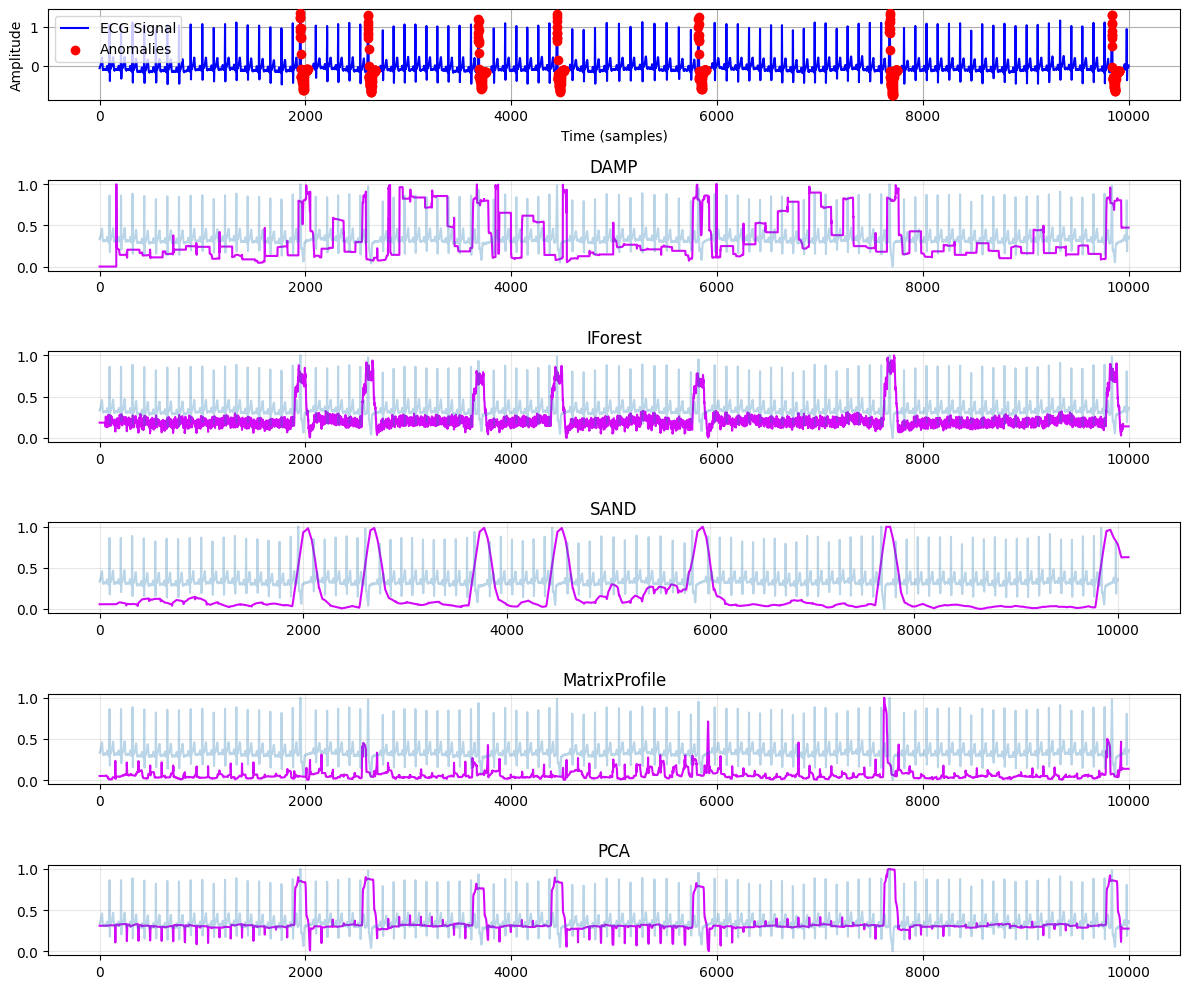

In [202]:
x_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(x.reshape(-1, 1)).ravel()

plt.figure(figsize=(12, 10))
plt.subplot(len(scores) + 1, 1, 1)
plot_signal_with_anomalies(x, y, title=file_path)

for i, elem in enumerate(scores):
    plt.subplot(len(scores) + 1, 1, i + 2)
    plt.title(elem['model_name'])
    plt.plot(elem['score'], color='#D30AFA')
    plt.plot(x_scaled, alpha=0.3)
    plt.grid(alpha=0.3)
    
plt.tight_layout()
plt.show()

**Write your answer here:**

MatrixProfile seems to be the most effective, as it has fewer fluctuations, better anomaly detection, and smoother transitions.

## Compute the accuracy

In [203]:
from sklearn.metrics import f1_score, precision_recall_curve, auc
from tsb_kit.vus.metrics import get_metrics

### Find the threshold for each score and save it in the 'scores' list 

In [204]:
for i, elem in enumerate(scores):
    elem['threshold'] = elem['score'].mean() + (3 * elem['score'].std())

for result in scores:
    print(f"Model: {result['model_name']}, Threshold: {result['threshold']:.4f}")


Model: DAMP, Threshold: 1.1079
Model: IForest, Threshold: 0.6716
Model: SAND, Threshold: 0.9688
Model: MatrixProfile, Threshold: 0.2853
Model: PCA, Threshold: 0.7801


### Compute the F1-score for each score and save it

**Question 6:** Use the anomaly threshold determined previously to compute the predicted label of 1s and 0s. Then, use it to compute the F1-score.

In [205]:
for i, elem in enumerate(scores):
       
    predicted_labels = (elem['score'] >= elem['threshold']).astype(int)
    
    true_labels = label[:len(predicted_labels)]  # Adjust according to the length of the predicted labels
    
    f1 = f1_score(true_labels, predicted_labels)
    
    elem['predicted_labels'] = predicted_labels
    elem['f1_score'] = f1
for elem in scores: print(f'{elem["model_name"]}: {elem["f1_score"]}')

DAMP: 0.0
IForest: 0.6943620178041543
SAND: 0.07407407407407407
MatrixProfile: 0.0
PCA: 0.6129334582942831


IForest seems to be the best for anomaly detection in this dataset, 
DAMP and MatrixProfile appear to perform very poorly, with F1-scores of 0.0, indicating no useful anomaly detection.based on its high F1-score.


### Visualize the 5 scores along with their thresholds and F1-scores. What do you notice?

**Question 7:** Why IForest, SAND and PCA have different F1-scores, although they seem to have the same accuracy? Write your answer in a cell below the plot.

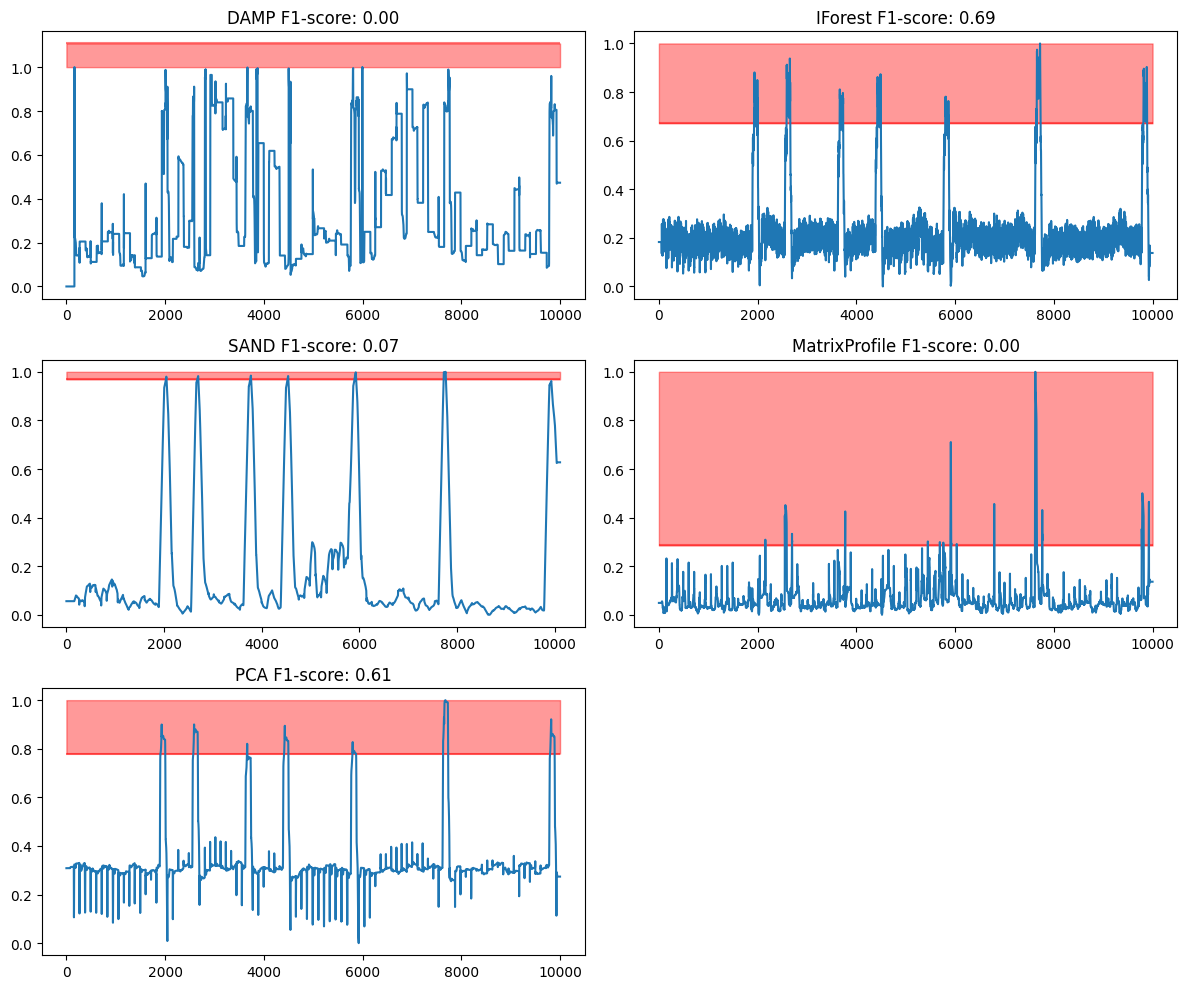

In [206]:
plt.figure(figsize=(12, 10))

for i, elem in enumerate(scores):
    plt.subplot(3, 2, i + 1)
    plt.hlines(y=elem['threshold'], xmin=0, xmax=len(elem['score']), color='red', alpha=0.5)
    plt.fill_between(x=np.arange(0, len(elem['score'])), y1=elem['threshold'], y2=1, color='red', alpha=0.4)
    plt.plot(elem['score'])
    plt.title(f"{elem['model_name']} F1-score: {elem['f1_score']:.2f}")

plt.tight_layout()
plt.show()

**Write your answer here:**

Visualizing the anomaly scores with their thresholds and F1-scores reveals key insights. IForest performs the best, with well-defined peaks in its scores and a high F1-score, indicating good anomaly detection. PCA and SAND show more erratic scores, resulting in moderate F1-scores. DAMP and MatrixProfile have F1-scores of 0, suggesting poor anomaly detection. The threshold (red line) separates anomalies from normal data, but its effectiveness varies across models. Overall, IForest is the most reliable for anomaly detection, while DAMP and MatrixProfile are less effective.

### Compute Precision and Recall and save them

**Question 8:** Fill in the code that's missing. Compute precision and recall for multiple different thresholds and save them in the list of dictionaries.

In [207]:
for elem in scores:
    min_length = min(len(true_labels), len(elem['score']))
    
    # Trim both to the same length
    adjusted_labels = true_labels[:min_length]
    adjusted_scores = elem['score'][:min_length]

    # Compute precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(adjusted_labels, adjusted_scores)
    
    # Store results
    elem['precision'] = precision
    elem['recall'] = recall
    elem['threshold_list'] = [thresholds[0]] + list(thresholds)


In [208]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds =  precision_recall_curve(adjusted_labels, adjusted_scores)
    


### Plot Precision, Recall and the Precision-Recall curve

**Question 9:** Which method do you now think is the best, and why? Write your answer in a cell below the plot.

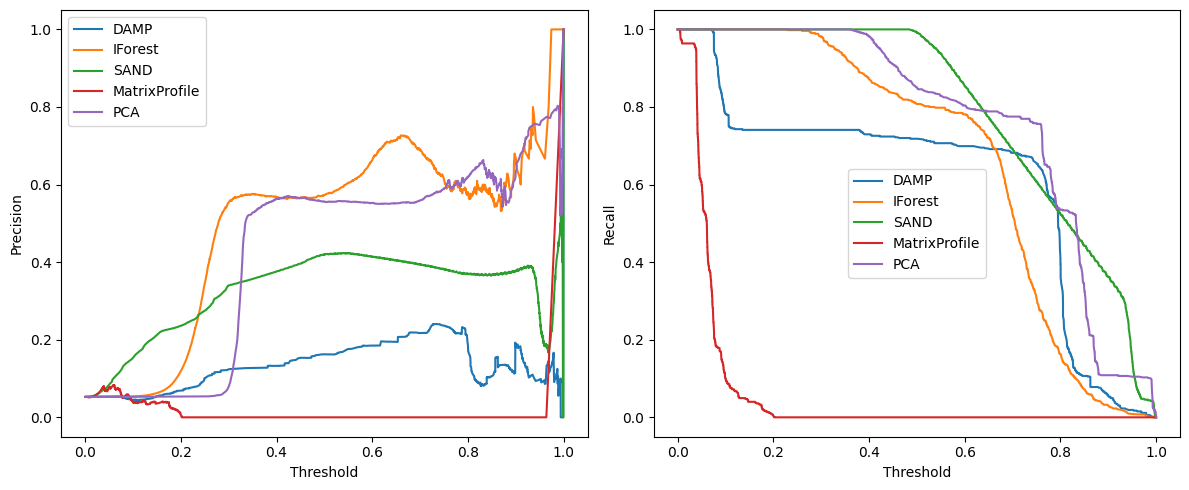

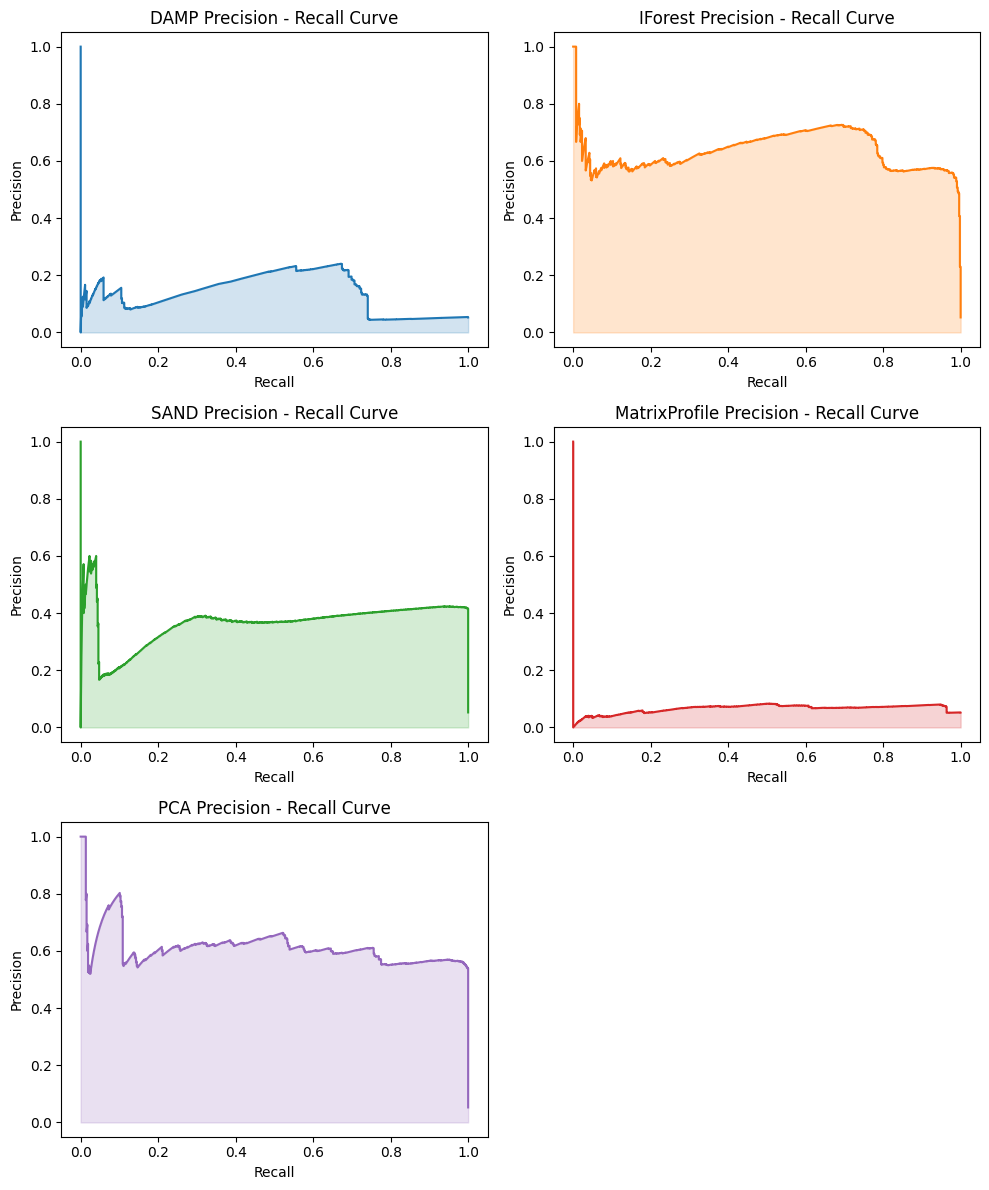

In [209]:
plt.figure(figsize=(12, 5))

# Plot Precision-Thresholds
plt.subplot(1, 2, 1)
for elem in scores:
    plt.plot(elem['threshold_list'], elem['precision'], label=elem['model_name'])
plt.ylabel('Precision')
plt.xlabel('Threshold')
plt.legend()

# Plot Recall-Thresholds
plt.subplot(1, 2, 2)
for elem in scores:
    plt.plot(elem['threshold_list'], elem['recall'], label=elem['model_name'])
plt.ylabel('Recall')
plt.xlabel('Threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 12))

for i, elem in enumerate(scores):
    plt.subplot(3, 2, i + 1)
    plt.plot(elem['recall'], elem['precision'], label=elem['model_name'], color=f'C{i}')
    plt.fill_between(elem['recall'], 0, elem['precision'], alpha=0.2, color=f'C{i}')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title(f"{elem['model_name']} Precision - Recall Curve")
plt.tight_layout()
plt.show()

**Write your answer here:**

IForest is a strong candidate as it maintains a good balance between precision and recall, making it a reliable anomaly detection method.
PCA also performs well, but its precision fluctuates more compared to IForest.

### Compute AUC-PR

**Question 10:** Fill in the code that's missing. Compute the AUC-PR (Area Under the Precision-Recall Curve) score and save it in *scores*.

In [210]:
from sklearn.metrics import average_precision_score


for i, elem in enumerate(scores):
  
    adjusted_labels = label[:len(elem['score'])]  # Ensure the length of the true labels matches the length of the scores
    adjusted_scores = elem['score']  # The scores computed by the anomaly detector
    
    # Compute the AUC-PR 
    elem['AUC_PR'] = average_precision_score(adjusted_labels, adjusted_scores)



### Compute AUC-ROC, VUS-PR, VUS-ROC

**Question 11:** Use the *get_metrics* function from the *vus* library to compute the metrics AUC-ROC, VUS-PR, VUS-ROC. Save them in *scores*.

In [211]:
from tsb_kit.vus.metrics import get_metrics

for elem in scores:
  
    results = get_metrics(adjusted_labels, adjusted_scores)
    
   
    print(results)



{'R_AUC_ROC': 0.549386015958009, 'R_AUC_PR': 0.5929702707086771, 'VUS_ROC': 0.5494047016318939, 'VUS_PR': 0.592999827704664}
{'R_AUC_ROC': 0.549386015958009, 'R_AUC_PR': 0.5929702707086771, 'VUS_ROC': 0.5494047016318939, 'VUS_PR': 0.592999827704664}
{'R_AUC_ROC': 0.549386015958009, 'R_AUC_PR': 0.5929702707086771, 'VUS_ROC': 0.5494047016318939, 'VUS_PR': 0.592999827704664}
{'R_AUC_ROC': 0.549386015958009, 'R_AUC_PR': 0.5929702707086771, 'VUS_ROC': 0.5494047016318939, 'VUS_PR': 0.592999827704664}
{'R_AUC_ROC': 0.549386015958009, 'R_AUC_PR': 0.5929702707086771, 'VUS_ROC': 0.5494047016318939, 'VUS_PR': 0.592999827704664}


In [212]:
from tsb_kit.vus.metrics import get_metrics

for elem in scores:
    
    results = get_metrics(adjusted_labels, adjusted_scores)
    
    # Assign the results to the respective keys in the 'elem' dictionary
    elem['AUC_ROC'] = results['R_AUC_ROC']
    elem['AUC_PR'] = results['R_AUC_PR']
    elem['VUS_ROC'] = results['VUS_ROC']
    elem['VUS_PR'] = results['VUS_PR']


In [213]:
df_scores = pd.DataFrame(scores)
df_scores[['model_name', 'f1_score', 'AUC_PR', 'AUC_ROC', 'VUS_PR', 'VUS_ROC']]

,model_name,f1_score,AUC_PR,AUC_ROC,VUS_PR,VUS_ROC
0,DAMP,0.000000,0.59297,0.549386,0.593,0.549405
1,IForest,0.694362,0.59297,0.549386,0.593,0.549405
2,SAND,0.074074,0.59297,0.549386,0.593,0.549405
3,MatrixProfile,0.000000,0.59297,0.549386,0.593,0.549405
4,PCA,0.612933,0.59297,0.549386,0.593,0.549405


### Visualize the results

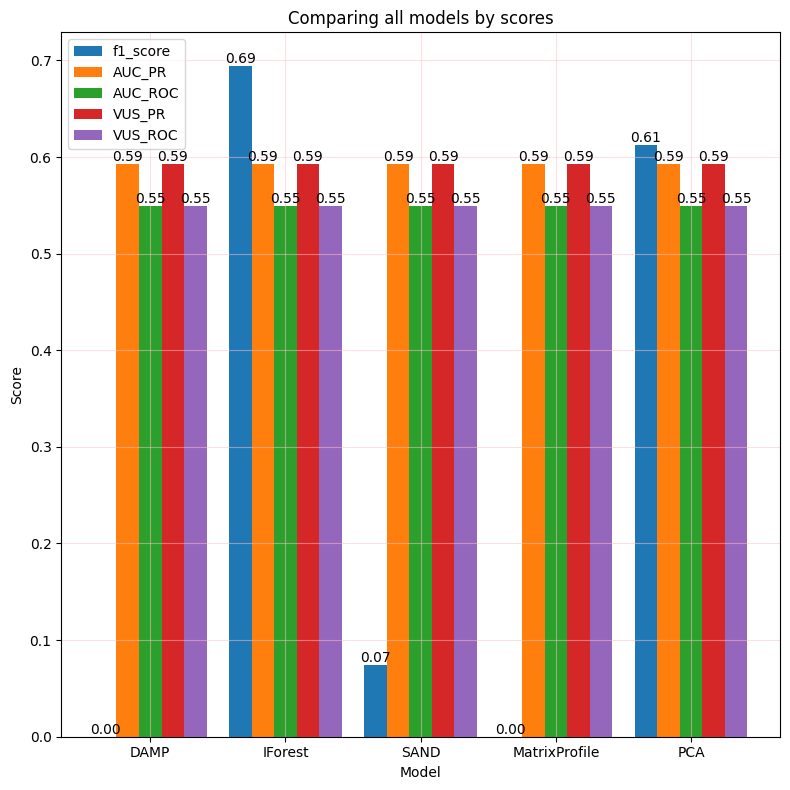

In [214]:
x = np.arange(0, len(df_scores['model_name']) * 3, 3)
bar_width = 0.5
results_show = ['f1_score', 'AUC_PR', 'AUC_ROC', 'VUS_PR', 'VUS_ROC']
offsets = np.arange(len(results_show)) - (len(results_show) // 2)

fig, ax = plt.subplots(figsize=(8, 8))
for key, offset in zip(results_show, offsets):
    bars = ax.bar(x + (bar_width * offset), df_scores[key], bar_width, label=key)
    ax.bar_label(bars, labels=[f"{x:.2f}" for x in df_scores[key]])

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Comparing all models by scores')
ax.set_xticks(x)
ax.set_xticklabels(df_scores['model_name'])
ax.legend()

plt.grid(color='pink', alpha=0.5)
plt.tight_layout()
plt.show()

### Measure Execution Time

**Question 12:** Rerun the anomaly detectors and compute execution time. Then create the same bar plot as above but for execution time and compare the detectors.

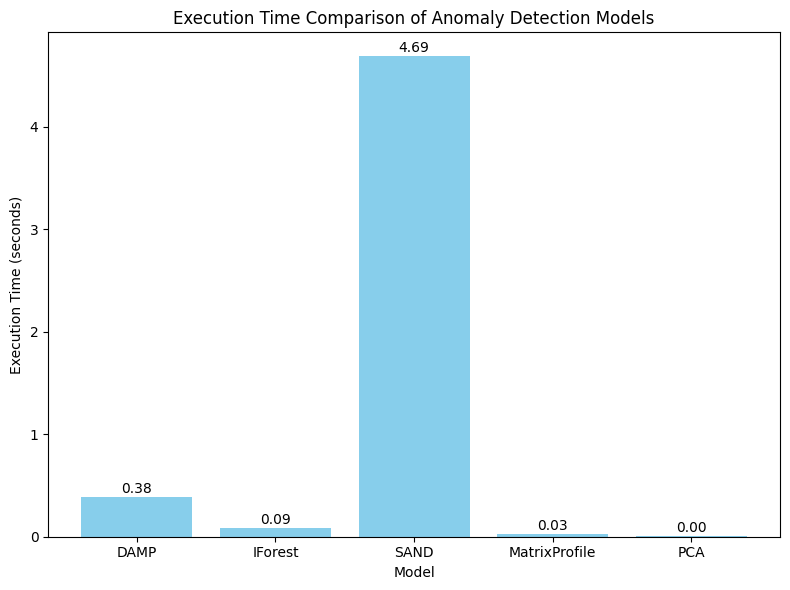

In [229]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tsb_kit.models.iforest import IForest
from tsb_kit.models.damp import DAMP
from tsb_kit.models.sand import SAND
from tsb_kit.models.matrix_profile import MatrixProfile
from tsb_kit.models.pca import PCA

# Example data (replace with actual time series data)
x = np.random.randn(1000)
slidingWindow = 108

# Check if the series is long enough for the window size

models = ['DAMP', 'IForest', 'SAND', 'MatrixProfile', 'PCA']
execution_times = {}

for model_name in models:
        start_time = time.time()

        # Adjust window size if needed
        current_window_size = min(slidingWindow, len(x) - 1)

        try:
            if model_name == 'DAMP':
                clf = DAMP(m=current_window_size, sp_index=current_window_size + 1)
                clf.fit(x)
            elif model_name == 'IForest':
                clf = IForest(n_jobs=4)
                clf.fit(x.reshape(-1, 1))
            elif model_name == 'SAND':
                clf = SAND(pattern_length=current_window_size, subsequence_length=4 * current_window_size)
                clf.fit(x)
            elif model_name == 'MatrixProfile':
                clf = MatrixProfile(window=current_window_size)
                clf.fit(x)
            elif model_name == 'PCA':
                clf = PCA()
                clf.fit(x.reshape(-1, 1))
        except Exception as e:
            print(f"Error with {model_name}: {e}")
            continue

        execution_times[model_name] = time.time() - start_time

 
 # Plot execution times
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(execution_times.keys(), execution_times.values(), color='skyblue')
ax.set_xlabel('Model')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Execution Time Comparison of Anomaly Detection Models')

for i, v in enumerate(execution_times.values()):
    ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
    

SAND is clearly the slowest model among those tested, which might make it less suitable for real-time or large-scale anomaly detection tasks.
MatrixProfile and PCA are the fastest, suggesting that they could be better choices if execution time is a critical factor.

# Analyse datasets

The following part of this session is **optional**.
1. Load three datasets
2. Run 5 detectors on each
3. Plot the AUC-PR and VUS-PR boxplots
4. What's the best detector now? Is there a best detector? Does this apply to all the time series of the dataset?

In [230]:
from tqdm import tqdm
from tsb_kit.models.distance import Fourier

tqdm.pandas()

## Load the datasets

In [237]:
# Add the paths of the datasets we are going to analyse and compare
dataset_path = os.path.join('..', 'data', 'TSB-UAD-Public')
datasets = ['SMD', 'SensorScope', 'MGAB']
dataset_paths = {}

for dataset in datasets:
    dataset_paths.update({
        dataset: os.path.join(dataset_path, dataset)
    })

In [238]:
# List all files in the dataset directory with '.out' extension
files_list = []
new_files_list = []
timeseries_len = 5000

for dataset in dataset_paths.keys():
    files_list.extend([{
    "dataset": dataset,
    "file_name": f,
} for i, f in enumerate(os.listdir(dataset_paths[dataset])[:20]) if f.endswith('.out') and i%2])

# Load them
for file in files_list:
    file_path = os.path.join(dataset_paths[file['dataset']], file['file_name'])
    df = pd.read_csv(file_path, header=None)
    tmp_data = df[0].to_numpy()
    tmp_label = df[1].to_numpy()

    # Find indices of anomalies
    anomaly_indices = np.where(tmp_label == 1)[0]
    
    if len(anomaly_indices) > 0:
        start_idx = max(0, anomaly_indices[0] - (timeseries_len // 2))
        end_idx = min(len(tmp_data), start_idx + timeseries_len)
        
        # Adjust start index if end index exceeds data length
        start_idx = max(0, end_idx - timeseries_len)
        
        file.update({
            "data": tmp_data[start_idx:end_idx],
            "label": tmp_label[start_idx:end_idx],
        })
        new_files_list.append(file)
    
df = pd.DataFrame(new_files_list)
df

,dataset,file_name,data,label
0,SMD,machine-2-1.test.csv@21.out,"[0.126423, 0.145705, 0.121348, 0.091047, 0.066...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,SMD,machine-3-6.test.csv@4.out,"[0.506696, 0.511161, 0.502232, 0.495536, 0.502...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,SMD,machine-2-8.test.csv@3.out,"[0.005745, 0.005334, 0.004377, 0.005471, 0.005...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,SMD,machine-2-8.test.csv@16.out,"[0.036171, 0.048875, 0.033844, 0.086695, 0.042...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,SMD,machine-1-5.test.csv@19.out,"[0.004454, 0.046627, 0.001749, 0.001913, 0.002...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,SensorScope,stb-12.test.out,"[0.0, 5.42, 5.6, 5.68, 5.72, 5.81, 5.72, 5.69,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,SensorScope,stb-7.test.out,"[5.75, 5.68, 5.72, 5.76, 5.66, 5.68, 5.59, 5.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,SensorScope,stb-9.test.out,"[0.0, 6.48, 6.36, 6.3, 6.23, 6.18, 6.18, 6.16,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,SensorScope,stb-17.test.out,"[6.62, 6.7, 6.82, 6.7, 6.72, 6.66, 6.66, 6.58,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,SensorScope,stb-5.test.out,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Run the Anomaly Detectors

### Prepare the data

In [249]:
df['sliding_window'] = df['data'].apply(find_length)
df['x_sub'] = df.progress_apply(lambda x: Window(window = x['sliding_window']).convert(x['data']).to_numpy(), axis=1)

100%|██████████| 15/15 [00:00<00:00, 112.46it/s]


## Run 5 detectors and collect their scores

**Question 13:** In each one of the function defined below, fill in the missing commands to create and fit the appropriate classifier according to the function's name.

In [250]:
from sklearn.preprocessing import MinMaxScaler
from tsb_kit.models.sand import SAND
from tsb_kit.models.poly import POLY
from tsb_kit.models.pca import PCA
from tsb_kit.models.iforest import IForest
from sklearn.svm import OneClassSVM
import math

# Function to normalize scores
def norm_score(score, sliding_window):
    score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
    score = np.array([score[0]] * math.ceil((sliding_window - 1) / 2) + list(score) + [score[-1]] * ((sliding_window - 1) // 2))
    return score

# Run SAND model
def run_SAND(x, sliding_window):
    clf = SAND(pattern_length=sliding_window, subsequence_length=4 * sliding_window)
    clf.fit(x)
    return MinMaxScaler(feature_range=(0, 1)).fit_transform(clf.decision_scores_.reshape(-1, 1)).ravel()

# Run POLY model (Fourier Transform)
def run_POLY(x, sliding_window):
    clf = POLY()
    clf.fit(x)
    measure = Fourier()
    measure.detector = clf
    measure.set_param()
    clf.decision_function(measure=measure)
    score = clf.decision_scores_
    return MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()

# Run PCA model
def run_PCA(x_sub, sliding_window):
    clf = PCA()
    clf.fit(x_sub)
    return norm_score(clf.decision_scores_, sliding_window)

# Run IForest model
def run_IForest(x_sub, sliding_window):
    clf = IForest()
    clf.fit(x_sub)
    return norm_score(clf.decision_scores_, sliding_window)

# Run OCSVM model
def run_OCSVM(X_train, X_test, sliding_window):
    clf = OneClassSVM(kernel='rbf', gamma='auto')
    clf.fit(X_train)
    score = clf.decision_function(X_test)
    return norm_score(score, sliding_window)


In [251]:
# Run the 5 detectors in all time series. This should take about 3 minutes
df['SAND_score'] = df.progress_apply(lambda x: run_SAND(x['data'], x['sliding_window']), axis=1)
df['POLY_score'] = df.progress_apply(lambda x: run_POLY(x['data'], x['sliding_window']), axis=1)
df['PCA_score'] = df.progress_apply(lambda x: run_PCA(x['x_sub'], x['sliding_window']), axis=1)
df['IForest_score'] = df.progress_apply(lambda x: run_IForest(x['x_sub'], x['sliding_window']), axis=1)
df['OCSVM_score'] = df.progress_apply(lambda x: run_OCSVM(x['x_sub'][:int(0.1*len(x['x_sub']))], x['x_sub'], x['sliding_window']), axis=1)

100%|██████████| 15/15 [00:02<00:00,  7.07it/s]


## Compute & Plot the AUC-PR in Boxplots

**Question 14:** Implement the following function to compute and return the Area Under the Precision-Recall Curve (AUC-PR). Given the true labels (y) of a time series and the corresponding detection scores (score), complete the function to perform this calculation

In [252]:
# TODO: Implement the following function
def compute_auc(y, score):
    return average_precision_score(y, score)

**Question 15:** Fill in the commands, and use the function you just implemented, to compute AUC-PR for all time series in the dataframe.

In [254]:
# List of detectors
detectors = ['POLY', 'PCA', 'IForest', 'SAND', 'OCSVM']

# Compute AUC-PR for every detector's score and each time series
for detector in detectors:
    df[f'{detector}_AUC_PR'] = df.progress_apply(lambda x: compute_auc(x['label'], x[f'{detector}_score']), axis=1)


100%|██████████| 15/15 [00:00<00:00, 1006.44it/s]


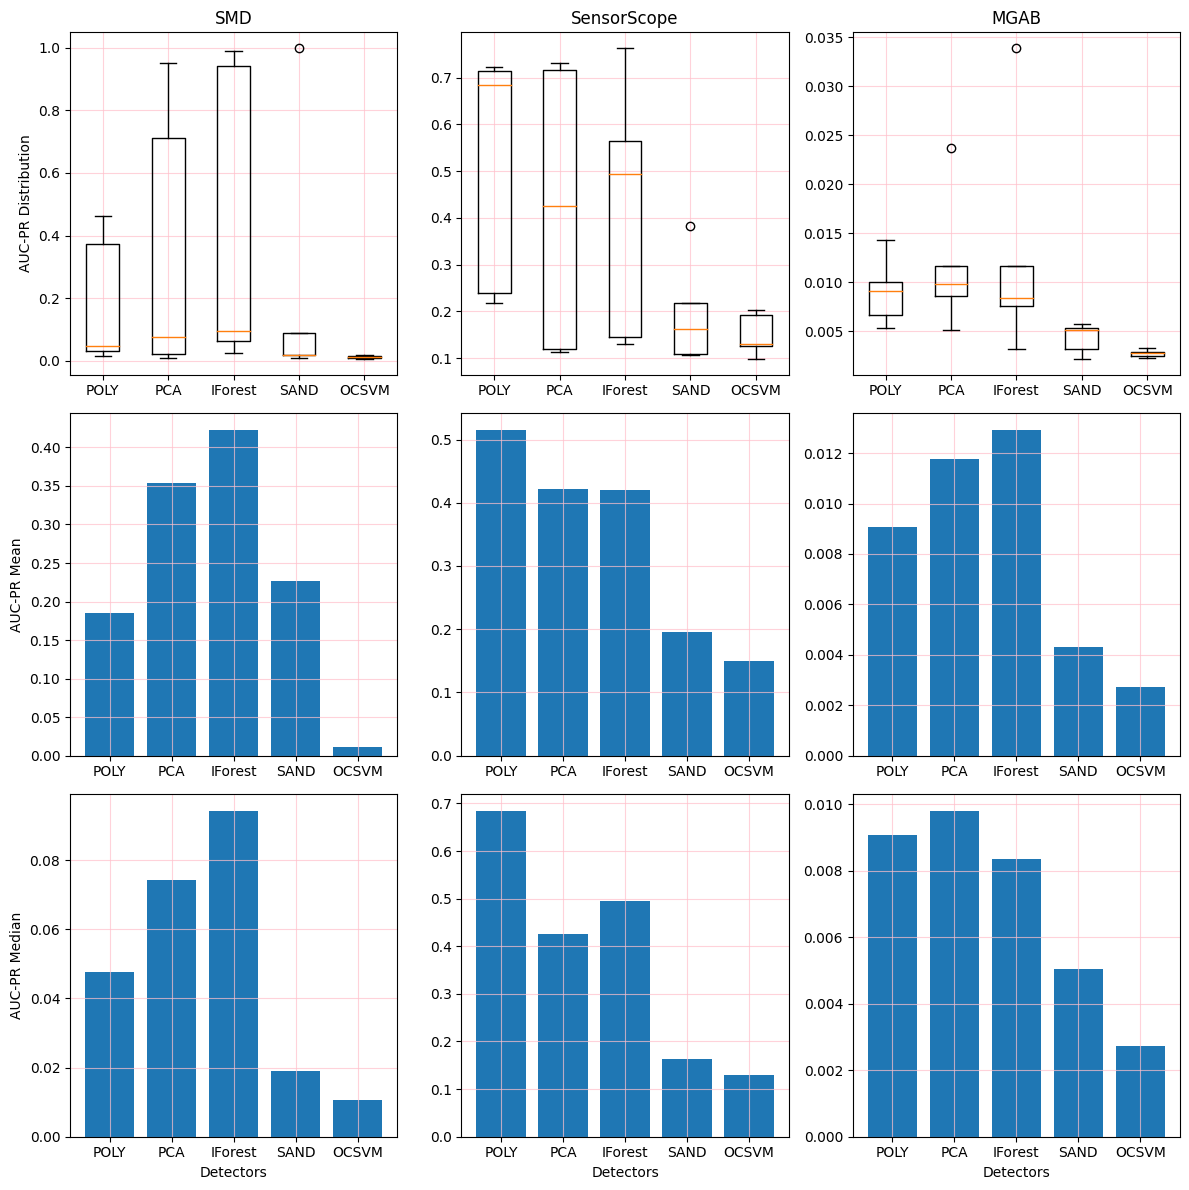

In [255]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, dataset in enumerate(datasets):
    tmp_df = df[df['dataset'] == dataset].filter(like='AUC_PR')
    tmp_df.columns = [x.replace('_AUC_PR', '') for x in tmp_df.columns]
    labels = list(tmp_df.columns)
    
    axes[0, i].boxplot(tmp_df.values)
    axes[0, i].set_xticks(ticks=np.arange(1, len(labels)+1), labels=labels)
    axes[0, i].set_title(dataset)
    
    axes[0, i].set_ylabel('AUC-PR Distribution') if i == 0 else None
    axes[0, i].grid(alpha=0.7, color='pink')

    axes[1, i].bar(x=list(tmp_df.columns), height=tmp_df.mean().values)
    axes[1, i].set_ylabel('AUC-PR Mean') if i == 0 else None
    axes[1, i].grid(alpha=0.7, color='pink')

    axes[2, i].bar(x=list(tmp_df.columns), height=tmp_df.median().values)
    axes[2, i].set_ylabel('AUC-PR Median') if i == 0 else None
    axes[2, i].grid(alpha=0.7, color='pink')
    axes[2, i].set_xlabel('Detectors')

plt.tight_layout()
plt.show()

# Bonus question: Can we do better ?
1. Averaging Ensemble
2. Model Selection

## Compute Averaging Ensemble score, its AUC-PR and put it in the box plot.

**Question 16:** Compute the Averaging Ensemble, that is the average of the anomaly scores that we computed before. Save it in the dataframe.

In [270]:
# Ensure all score columns are numeric
for detector in ['SAND_score', 'POLY_score', 'PCA_score', 'IForest_score', 'OCSVM_score']:
    # Convert to numeric
    df[detector] = pd.to_numeric(df[detector], errors='coerce')

df.fillna(0, inplace=True)

for detector in ['SAND_score', 'POLY_score', 'PCA_score', 'IForest_score', 'OCSVM_score']:
    df[detector] = np.ravel(df[detector])

# Now compute the Averaging Ensemble for each time series
scores_df = df.filter(like='_score')
df['AVG_ENS_score'] = scores_df.mean(axis=1)


In [272]:
# Drop 'AVG_ENS_score' column if it exists
if 'AVG_ENS_score' in df.columns:
    df = df.drop('AVG_ENS_score', axis=1)

scores_df = df.filter(like='_score')

# TODO: Calculate the averaging ensemble for each time series
df['AVG_ENS_score'] = scores_df.mean(axis=1)

In [273]:
# Ensure AVG_ENS_score is an array 
df['AVG_ENS_score'] = np.array(df['AVG_ENS_score'])


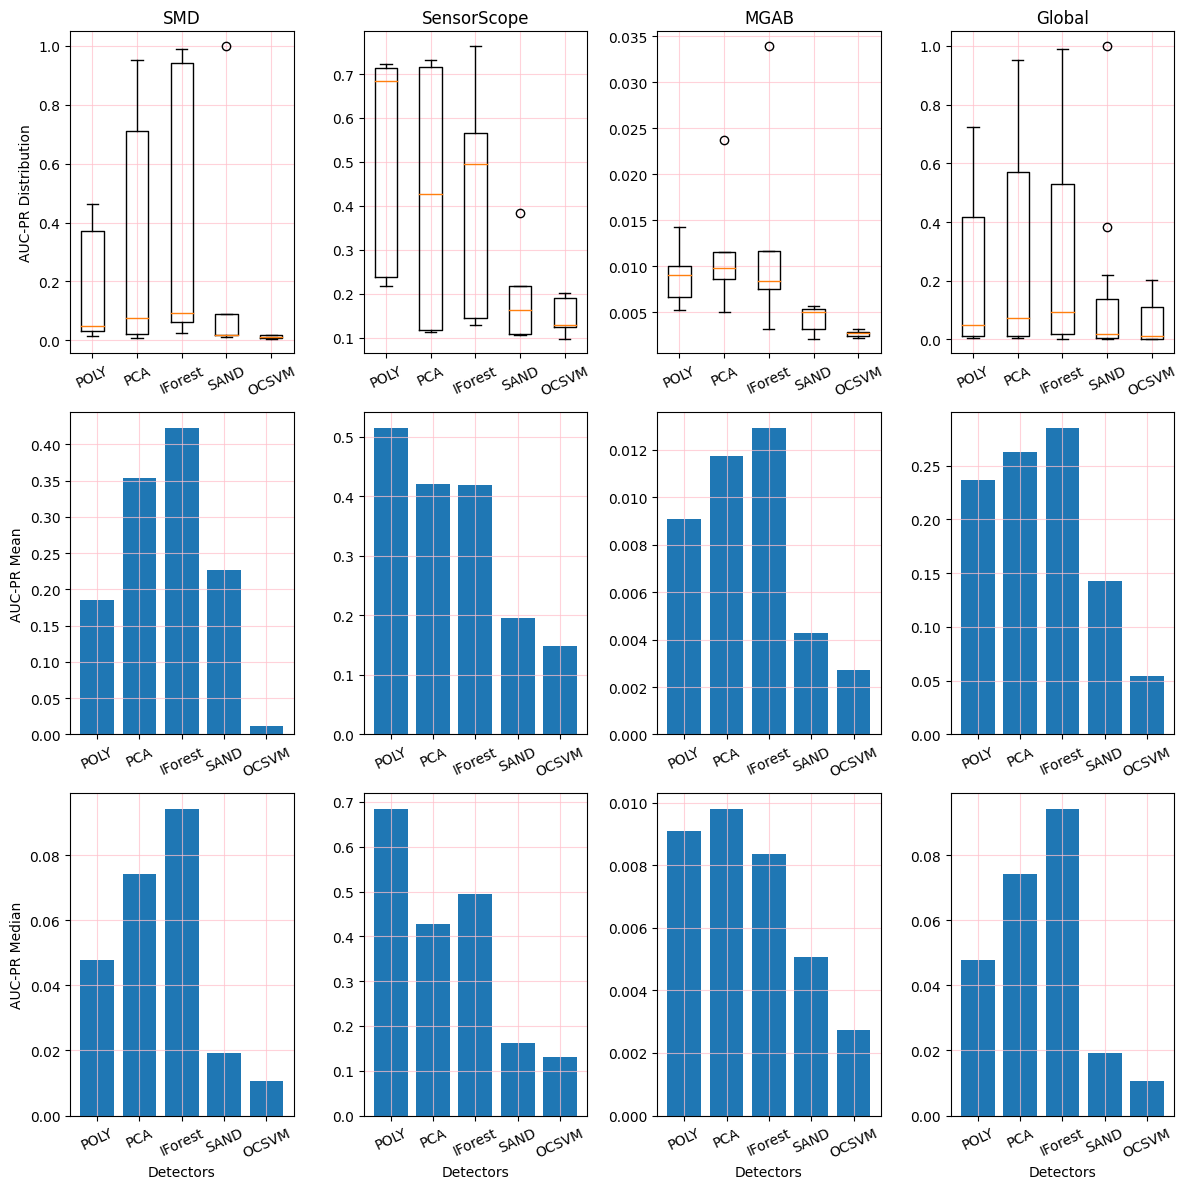

In [274]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i, dataset in enumerate(datasets):
    tmp_df = df[df['dataset'] == dataset].filter(like='AUC_PR')
    tmp_df.columns = [x.replace('_AUC_PR', '') for x in tmp_df.columns]
    labels = list(tmp_df.columns)
    
    axes[0, i].boxplot(tmp_df.values)
    axes[0, i].set_xticks(ticks=np.arange(1, len(labels)+1), labels=labels)
    axes[0, i].set_title(dataset)
    
    axes[0, i].set_ylabel('AUC-PR Distribution') if i == 0 else None

    axes[1, i].bar(x=list(tmp_df.columns), height=tmp_df.mean().values)
    axes[1, i].set_ylabel('AUC-PR Mean') if i == 0 else None

    axes[2, i].bar(x=list(tmp_df.columns), height=tmp_df.median().values)
    axes[2, i].set_ylabel('AUC-PR Median') if i == 0 else None
    axes[2, i].set_xlabel('Detectors')

    for k in range(3):
        axes[k, i].grid(alpha=0.7, color='pink') 
        axes[k, i].tick_params(axis='x', labelrotation=25)

# Global results
tmp_df = df.filter(like='AUC_PR')
tmp_df.columns = [x.replace('_AUC_PR', '') for x in tmp_df.columns]
labels = list(tmp_df.columns)

axes[0, 3].boxplot(tmp_df.values)
axes[0, 3].set_xticks(ticks=np.arange(1, len(labels)+1), labels=labels)
axes[0, 3].set_title("Global")
axes[0, 3].set_ylabel('AUC-PR Distribution') if i == 0 else None

axes[1, 3].bar(x=list(tmp_df.columns), height=tmp_df.mean().values)
axes[1, 3].set_ylabel('AUC-PR Mean') if i == 0 else None

axes[2, 3].bar(x=list(tmp_df.columns), height=tmp_df.median().values)
axes[2, 3].set_ylabel('AUC-PR Median') if i == 0 else None
axes[2, 3].set_xlabel('Detectors')

for k in range(3):
    axes[k, 3].grid(alpha=0.7, color='pink') 
    axes[k, 3].tick_params(axis='x', labelrotation=25)

plt.tight_layout()
plt.show()

## Model Selection

**Question (Bonus):** Can we do better than that? If yes, why? Does it work in all cases? Visit the ADecimo webapp tool (link in the repo), find out and write your answer in the cell below. 

**Question (Super extra bonus):** Clone the MSAD repository and evaluate a pretrained model (or train it from scratch :) ), on the datasets we saw here. Visualize your results and paste them here along with your findings! Did you face any issues? Describe the process.

**Write your answer here:**

Yes, anomaly detection can be improved beyond individual models or averaging ensembles. Techniques such as stacking, where multiple models' predictions are combined using a secondary model like logistic regression or SVM, can offer better performance. Hyperparameter tuning allows fine-tuning models like Isolation Forest and SAND for optimal results. More advanced models like autoencoders and LSTM networks can capture complex patterns in time series data for anomaly detection. Additionally, incorporating semi-supervised learning and feature engineering, such as extracting relevant features or using domain knowledge can further enhance model performance. However, these strategies may not always perform well in noisy data, when anomalies aren't well-represented across models, or in real-time systems where simpler models may be more efficient.